In [ ]:
# 1. Compare models on 10, 20, 30
# 2. Visualization 
# 3. 

In [77]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
from collections import defaultdict
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
import pandas as pd
import torch.nn.functional as F
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
    ]) 
    return transform(image).unsqueeze(0)

def get_indexes(arr, value):
    indexes = []
    for i in range(len(arr)):
        if arr[i] == value:
            indexes.append(i)
    return indexes

def get_length_per_class(dataloader, classes):
    class_counts = defaultdict(int)
    total = 0
    for batch in dataloader:
        _, labels = batch 
        labels = labels.numpy().tolist()
        for label in labels:
            class_counts[label] += 1
            total +=1

    class_counts = dict(sorted(class_counts.items()))
    for class_label, count in class_counts.items():
        print(f"Class {classes[class_label]}: {count} samples out of {total}")
def load_data(data_dir,
                           batch_size,
                           data_type,
                           noise_type,
                           noise_percentage,                           
                           transform,                           
                           data_percentage=1,
                           show_classes = False, random_seed=21):
    
    if noise_type == "None":
        noise_type = ""
        noise_percentage = ""
    else:
        noise_type = "/" + str(noise_type)
        noise_percentage = "/" + str(noise_percentage)
    path = data_dir + noise_type + "/" + data_type + noise_percentage
    print("path: ", path)
    dataset = ImageFolder(root=path, transform=transform)
    original_classes = dataset.classes 
    num_samples = len(dataset)
    indices = list(range(num_samples))

    labels = dataset.targets
    class_to_idx = dataset.class_to_idx
    needed_length = int(num_samples*data_percentage/100)
    expected_length_per_class = int(needed_length/len(original_classes))
    print(f"needed_length: {needed_length}, expected_length_per_class: {expected_length_per_class}")
    if data_percentage != 100:
        new_indices = []
        for key, value in class_to_idx.items():
            all_indixes_of_class = get_indexes(labels, value)
            new_indices.extend(all_indixes_of_class[:expected_length_per_class])
    else:
        new_indices = indices
    length_dataset = len(new_indices)
    print("length of final dataset:", length_dataset)

    
    # sampler = SubsetRandomSampler(new_indices)

    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    if show_classes:
        get_length_per_class(dataloader, original_classes)
        
    random.shuffle(new_indices)

   
    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    return dataloader, length_dataset, original_classes

def testing(model, classes, noise_percentage):

    results = pd.DataFrame(columns = ['Class', 'Noise Percentage', 'Accuracy', 'Recall', 'Precision', 'F_score', 'time'])
    data = pd.DataFrame(columns = ['t', 'p', 'tf', 'noise_percentage'])
    model.eval()
    y_pred1 = torch.tensor([])
    y_target1 = torch.tensor([])
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(len(classes))]
        n_class_samples = [0 for _ in range(len(classes))]
        n_class_true_positives = [0 for _ in range(len(classes))]
        n_class_preds = [0 for _ in range(len(classes))]
        diff = 0
        for images, labels in test_loader_dict[noise_percentage]:
            images = images.to(device)
            labels = labels.to(device)
            s = time.time()
            outputs = model(images)
            e = time.time()
            diff += (e-s)
            _, predicted = torch.max(outputs, 1)
            t_values = labels.cpu().numpy()  
            p_values = predicted.cpu().numpy()  
            tf_values = (t_values == p_values).astype(int)  
            batch_data = pd.DataFrame({'t': t_values, 'p': p_values, 'tf': tf_values, 'noise_percentage': noise_percentage})
            data = pd.concat([data, batch_data], ignore_index=True)
             
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            y_pred1 = y_pred1.to(predicted.device)
            y_target1 = y_target1.to(labels.device)

            y_pred1 = torch.cat((predicted, y_pred1), dim=0)
            y_target1 = torch.cat((labels, y_target1), dim=0)
            
            for i in range(len(images)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class_preds[pred] +=1                
                n_class_true_positives[pred] += int(pred == label)
                


        acc = round(100.0 * n_correct / n_samples, 2)
        print(f'Accuracy of the network: {acc} %')

        for i in range(len(classes)):
            
            precision = round(n_class_true_positives[i] / n_class_preds[i], 2) if n_class_preds[i] != 0 else 0
            recall = round(n_class_true_positives[i] /n_class_samples[i], 2)
            f_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
            
            
            results.loc[len(results.index)] = [classes[i], noise_percentage, n_class_correct[i] *100 / n_class_samples[i], recall, precision, f_score, diff] 
            
        results.loc[len(results.index)] = ['Total', noise_percentage, acc, round(results['Recall'].mean(),2),
                                            round(results['Precision'].mean(), 2), round(results['F_score'].mean(), 2), diff] 
        
        return results, data











path_to_10 = "/kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/10/Bean/0002.jpg"
path_to_20 = "/kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/20/Bean/0002.jpg"
path_to_30 = "/kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/30/Bean/0002.jpg"
path_to_50 = "/kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/50/Bean/0002.jpg"
path_to_100 = "/kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/100/Bean/0002.jpg"

print('ready')





ready


In [72]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
])   

noise_type = "gaussian_noise"
noise_percentage = 10
data_percentage = 100
total_size = 21000

train_size = data_percentage*total_size/100
data_dir = '/kaggle/input/vegetableimages3/vegetable_images'

train_loader, train_size, classes = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "train",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader, valid_size, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader_with_noise, _, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = noise_type,
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataloaders = {'train':  train_loader, 
               'val': valid_loader
               }
dataloaders_with_noise = {'train':  train_loader, 
               'val': valid_loader_with_noise
               }


test_loader,test_size_, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)


test_loader_without_noise, _, _ = load_data(data_dir =data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataset_sizes = {'train':  train_size, 
        'val': valid_size,
        'test': test_size_
       }


test_loader_dict = {0: test_loader_without_noise}

n = [10, 20, 30, 50, 70, 100]


for i in n:
    test_loader,test_size_, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = i,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
    
    test_loader_dict[i] = test_loader
    

path:  /kaggle/input/vegetableimages3/vegetable_images/train
needed_length: 15000, expected_length_per_class: 1000
length of final dataset: 15000
path:  /kaggle/input/vegetableimages3/vegetable_images/validation
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  /kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/validation/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  /kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  /kaggle/input/vegetableimages3/vegetable_images/test
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  /kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  /kaggle/input/vegetableimages3/vegetable_images/gaussian_noise/test/20


In [8]:
path = "/kaggle/input/models/models/"
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

alexnet = torch.load(path + "best_alexnet.pth", map_location=torch.device(device))
efficientnet = torch.load(path + "best_efficientnet.pth", map_location=torch.device(device))
resnet = torch.load(path + "best_resnet.pth", map_location=torch.device(device))
vgg16 = torch.load(path + "best_vgg16.pth", map_location=torch.device(device))

/opt/conda/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [149]:
res, data = testing(efficientnet, classes, 10)
data

Accuracy of the network: 98.13 %


,t,p,tf,noise_percentage
0,3,3,1,10
1,12,12,1,10
2,2,2,1,10
3,9,9,1,10
4,14,14,1,10
...,...,...,...,...
2995,8,8,1,10
2996,6,6,1,10
2997,6,6,1,10
2998,10,10,1,10


In [22]:
res

,Class,Accuracy,Recall,Precision,F_score
0,Bean,99.50,0.99,0.99,0.99
1,Bitter_Gourd,99.00,0.99,0.96,0.97
2,Bottle_Gourd,91.00,0.91,0.99,0.95
3,Brinjal,98.50,0.98,0.95,0.96
4,Broccoli,98.00,0.98,0.99,0.98
5,Cabbage,99.00,0.99,0.99,0.99
6,Capsicum,97.50,0.97,0.99,0.98
7,Carrot,99.50,0.99,1.00,0.99
8,Cauliflower,97.00,0.97,0.99,0.98
9,Cucumber,99.00,0.99,0.93,0.96


In [78]:
ns = [10, 20, 30, 50, 70, 100]

for n in ns:
    res, data = testing(alexnet, classes, n)
    res.to_csv("alexnet_res_" + str(n) +".csv", index = False)
    data.to_csv("alexnet_data_" + str(n) +".csv", index = False)

res
    

Accuracy of the network: 98.97 %
Accuracy of the network: 89.87 %
Accuracy of the network: 69.4 %
Accuracy of the network: 35.63 %
Accuracy of the network: 17.73 %
Accuracy of the network: 12.37 %


,Class,Noise Percentage,Accuracy,Recall,Precision,F_score,time
0,Bean,100,0.50,0.01,1.00,0.02,0.06752
1,Bitter_Gourd,100,100.00,1.00,0.10,0.18,0.06752
2,Bottle_Gourd,100,5.00,0.05,0.83,0.09,0.06752
3,Brinjal,100,0.00,0.00,0.00,0.00,0.06752
4,Broccoli,100,48.50,0.48,0.12,0.19,0.06752
5,Cabbage,100,0.00,0.00,0.00,0.00,0.06752
6,Capsicum,100,0.00,0.00,0.00,0.00,0.06752
7,Carrot,100,0.00,0.00,0.00,0.00,0.06752
8,Cauliflower,100,0.00,0.00,0.00,0.00,0.06752
9,Cucumber,100,0.00,0.00,0.00,0.00,0.06752


In [79]:
ns = [10, 20, 30, 50, 70, 100]

for n in ns:
    res, data = testing(efficientnet, classes, n)
    res.to_csv("efficientnet_res_" + str(n) +".csv", index = False)
    data.to_csv("efficientnet_data_" + str(n) +".csv", index = False)
res
    

Accuracy of the network: 98.13 %
Accuracy of the network: 91.0 %
Accuracy of the network: 77.23 %
Accuracy of the network: 45.2 %
Accuracy of the network: 20.1 %
Accuracy of the network: 11.3 %


,Class,Noise Percentage,Accuracy,Recall,Precision,F_score,time
0,Bean,100,7.0,0.07,0.93,0.13,0.507991
1,Bitter_Gourd,100,97.0,0.97,0.12,0.21,0.507991
2,Bottle_Gourd,100,0.0,0.00,0.00,0.00,0.507991
3,Brinjal,100,0.0,0.00,0.00,0.00,0.507991
4,Broccoli,100,55.0,0.55,0.08,0.14,0.507991
5,Cabbage,100,0.0,0.00,0.00,0.00,0.507991
6,Capsicum,100,0.0,0.00,0.00,0.00,0.507991
7,Carrot,100,0.0,0.00,0.00,0.00,0.507991
8,Cauliflower,100,0.0,0.00,0.00,0.00,0.507991
9,Cucumber,100,0.5,0.01,0.50,0.02,0.507991


In [80]:
ns = [10, 20, 30, 50, 70, 100]

for n in ns:
    res, data = testing(resnet, classes, n)
    res.to_csv("resnet_res_" + str(n) +".csv", index = False)
    data.to_csv("resnet_data_" + str(n) +".csv", index = False)
res
    

Accuracy of the network: 98.3 %
Accuracy of the network: 93.37 %
Accuracy of the network: 86.23 %
Accuracy of the network: 61.93 %
Accuracy of the network: 36.23 %
Accuracy of the network: 16.93 %


,Class,Noise Percentage,Accuracy,Recall,Precision,F_score,time
0,Bean,100,22.00,0.22,0.70,0.33,0.676876
1,Bitter_Gourd,100,56.50,0.56,0.18,0.27,0.676876
2,Bottle_Gourd,100,0.50,0.01,1.00,0.02,0.676876
3,Brinjal,100,0.00,0.00,0.00,0.00,0.676876
4,Broccoli,100,89.00,0.89,0.14,0.24,0.676876
5,Cabbage,100,1.00,0.01,0.02,0.01,0.676876
6,Capsicum,100,0.00,0.00,0.00,0.00,0.676876
7,Carrot,100,1.50,0.01,0.75,0.02,0.676876
8,Cauliflower,100,0.00,0.00,0.00,0.00,0.676876
9,Cucumber,100,0.00,0.00,0.00,0.00,0.676876


In [81]:
ns = [10, 20, 30, 50, 70, 100]

for n in ns:
    res, data = testing(vgg16, classes, n)
    res.to_csv("vgg16_res_" + str(n) +".csv", index = False)
    data.to_csv("vgg16_data_" + str(n) +".csv", index = False)
res

Accuracy of the network: 97.7 %
Accuracy of the network: 73.27 %
Accuracy of the network: 44.1 %
Accuracy of the network: 21.0 %
Accuracy of the network: 13.57 %
Accuracy of the network: 9.93 %


,Class,Noise Percentage,Accuracy,Recall,Precision,F_score,time
0,Bean,100,0.00,0.00,0.00,0.00,12.197446
1,Bitter_Gourd,100,0.00,0.00,0.00,0.00,12.197446
2,Bottle_Gourd,100,0.00,0.00,0.00,0.00,12.197446
3,Brinjal,100,0.00,0.00,0.00,0.00,12.197446
4,Broccoli,100,84.00,0.84,0.08,0.15,12.197446
5,Cabbage,100,0.00,0.00,0.00,0.00,12.197446
6,Capsicum,100,0.00,0.00,0.00,0.00,12.197446
7,Carrot,100,0.00,0.00,0.00,0.00,12.197446
8,Cauliflower,100,0.00,0.00,0.00,0.00,12.197446
9,Cucumber,100,0.50,0.01,0.12,0.02,12.197446


In [84]:
!zip -r file.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/efficientnet_data_70.csv (deflated 86%)
updating: kaggle/working/resnet_data_30.csv (deflated 87%)
updating: kaggle/working/resnet_res_100.csv (deflated 64%)
updating: kaggle/working/alexnet_data_30.csv (deflated 86%)
updating: kaggle/working/alexnet_data_70.csv (deflated 86%)
updating: kaggle/working/vgg16_data_20.csv (deflated 87%)
updating: kaggle/working/efficientnet_data_10.csv (deflated 88%)
updating: kaggle/working/efficientnet_data_50.csv (deflated 85%)
updating: kaggle/working/resnet_res_50.csv (deflated 61%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/vgg16_data_100.csv (deflated 89%)
updating: kaggle/working/alexnet_res_20.csv (deflated 63%)
updating: kaggle/working/efficientnet_res_100.csv (deflated 67%)
updating: kaggle/working/alexnet_data_20.csv (deflated 87%)
updating: kaggle/working/resnet_data_70.csv (deflated 86%)
updating: kaggle/working/vgg16_res_10.csv (deflated 67

In [85]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [86]:
d ={}
dir_path = "/kaggle/input/results1/kaggle/working/"
ns = [10, 20, 30, 50, 70, 100]

models = ['alexnet', 'efficientnet', 'vgg16', 'resnet']

for m in models:
    d[m] = {}
    for n in ns:    
        d[m][n] = pd.read_csv(dir_path + m + "_res_" + str(n) + '.csv', sep = ',')







In [87]:
d['efficientnet'][10].loc[d['efficientnet'][10]['Class'] == 'Total', 'F_score'].values[0]


0.98

In [88]:
final_result = pd.DataFrame(columns = ['model', 'noise_percentage', 'accuracy', 'precision', 'f', 'time'])

In [89]:
for m in models:
    for n in ns:  
        final_result.loc[len(final_result)] = [m, n, d[m][n].loc[d[m][n]['Class'] == 'Total', 'Accuracy' ].values[0],
                                             d[m][n].loc[d[m][n]['Class'] == 'Total', 'Precision' ].values[0],
                                            d[m][n].loc[d[m][n]['Class'] == 'Total', 'F_score' ].values[0],
                                              d[m][n].loc[d[m][n]['Class'] == 'Total', 'time' ].values[0]]
        

In [90]:
final_result

,model,noise_percentage,accuracy,precision,f,time
0,alexnet,10,98.97,0.99,0.99,0.065041
1,alexnet,20,89.87,0.92,0.89,0.067039
2,alexnet,30,69.40,0.83,0.67,0.069369
3,alexnet,50,35.63,0.69,0.32,0.065450
4,alexnet,70,17.73,0.50,0.13,0.066625
5,alexnet,100,12.37,0.27,0.07,0.067520
6,efficientnet,10,98.13,0.98,0.98,0.582861
7,efficientnet,20,91.00,0.93,0.91,0.497380
8,efficientnet,30,77.23,0.85,0.77,0.489493
9,efficientnet,50,45.20,0.73,0.46,0.500348


In [31]:
ns = [10, 20, 30]

for n in ns:
    display(final_result.sort_values(by = ['accuracy'], ascending = False).loc[final_result['noise_percentage'] == n, :].reset_index(drop = True))

,model,noise_percentage,accuracy,precision,f,time
0,alexnet,10,98.97,0.99,0.99,0.071052
1,resnet,10,98.30,0.98,0.98,0.781297
2,efficientnet,10,98.13,0.98,0.98,0.595208
3,vgg16,10,97.70,0.98,0.97,0.156562


,model,noise_percentage,accuracy,precision,f,time
0,resnet,20,93.37,0.94,0.93,0.687701
1,efficientnet,20,91.00,0.93,0.91,0.510468
2,alexnet,20,89.87,0.92,0.89,0.062403
3,vgg16,20,73.27,0.82,0.71,0.104834


,model,noise_percentage,accuracy,precision,f,time
0,resnet,30,86.23,0.91,0.86,0.677682
1,efficientnet,30,77.23,0.85,0.77,0.495905
2,alexnet,30,69.40,0.83,0.67,0.063276
3,vgg16,30,44.10,0.65,0.39,0.102074


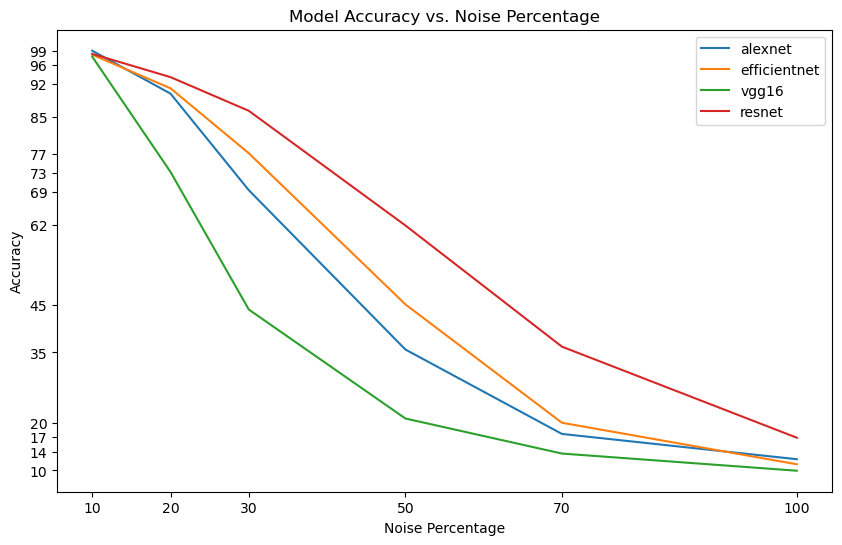

In [37]:
plt.figure(figsize=(10, 6))
acc = [10, 14, 17, 20, 35, 45, 62, 69, 73, 77, 85, 92, 96, 99]
models = ['alexnet', 'efficientnet', 'vgg16', 'resnet']

for model in models:
    model_data = final_result[final_result['model'] == model]
    accuracy_data = model_data['accuracy']
    plt.plot(model_data['noise_percentage'],accuracy_data, label = model)
    
plt.xlabel('Noise Percentage')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Noise Percentage')
plt.legend()
plt.xticks(model_data['noise_percentage'])
plt.yticks(acc)
plt.show()

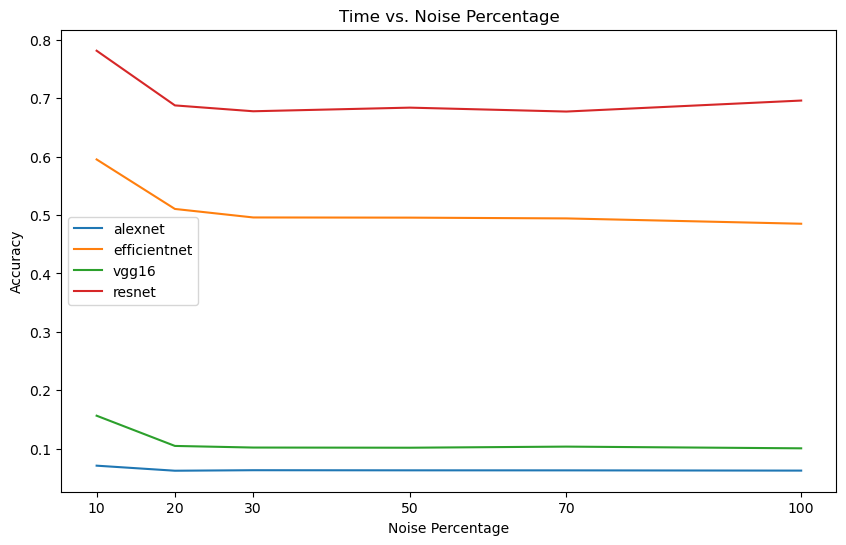

In [45]:
plt.figure(figsize=(10, 6))

models = ['alexnet', 'efficientnet', 'vgg16', 'resnet']
ts = []
for model in models:
    model_data = final_result[final_result['model'] == model]
    t = model_data['time']
    ts.extend(t)
    plt.plot(model_data['noise_percentage'],t, label = model)
    
plt.xlabel('Noise Percentage')
plt.ylabel('Accuracy')
plt.title('Time vs. Noise Percentage')
plt.legend()
plt.xticks(model_data['noise_percentage'])
plt.show()

In [92]:
ns = [10, 20, 30, 50, 70, 100]
data_columns = ['model', 'Noise Percentage', 'Class', 'Accuracy', 'Recall', 'Precision', 'F_score', 'time']
models = ['alexnet', 'efficientnet', 'vgg16', 'resnet']
res_final = pd.DataFrame(columns = data_columns)
for m in models:
    for n in ns:    
        d1= pd.read_csv(dir_path + m + "_res_" + str(n) + '.csv', sep = ',')
        d1['model'] = m
        res_final = pd.concat([res_final, d1], ignore_index=True)
        

In [93]:
res_final

,model,Noise Percentage,Class,Accuracy,Recall,Precision,F_score,time
0,alexnet,10,Bean,99.00,0.99,0.99,0.99,0.065041
1,alexnet,10,Bitter_Gourd,99.00,0.99,1.00,0.99,0.065041
2,alexnet,10,Bottle_Gourd,100.00,1.00,0.99,0.99,0.065041
3,alexnet,10,Brinjal,97.50,0.97,0.99,0.98,0.065041
4,alexnet,10,Broccoli,100.00,1.00,1.00,1.00,0.065041
...,...,...,...,...,...,...,...,...
379,resnet,100,Potato,2.50,0.03,0.50,0.06,0.676876
380,resnet,100,Pumpkin,43.00,0.43,0.11,0.18,0.676876
381,resnet,100,Radish,11.00,0.11,0.88,0.20,0.676876
382,resnet,100,Tomato,27.00,0.27,0.77,0.40,0.676876


In [108]:
res_per_class = res_final.loc[res_final.groupby(['Class', 'Noise Percentage'])['Accuracy'].idxmax()].reset_index(drop=True)
res_per_class = res_per_class[(res_per_class['Class']!='Total') & (res_per_class['Noise Percentage'] <40)].reset_index(drop = True)

res_per_class[res_per_class['Noise Percentage'] ==  10]

,model,Noise Percentage,Class,Accuracy,Recall,Precision,F_score,time
0,vgg16,10,Bean,100.0,1.00,0.97,0.98,12.194189
3,alexnet,10,Bitter_Gourd,99.0,0.99,1.00,0.99,0.065041
6,alexnet,10,Bottle_Gourd,100.0,1.00,0.99,0.99,0.065041
9,efficientnet,10,Brinjal,98.5,0.98,0.95,0.96,0.582861
12,alexnet,10,Broccoli,100.0,1.00,1.00,1.00,0.065041
15,alexnet,10,Cabbage,99.5,0.99,0.99,0.99,0.065041
18,efficientnet,10,Capsicum,97.5,0.97,0.99,0.98,0.582861
21,alexnet,10,Carrot,100.0,1.00,1.00,1.00,0.065041
24,alexnet,10,Cauliflower,99.5,0.99,0.99,0.99,0.065041
27,alexnet,10,Cucumber,99.5,0.99,0.98,0.98,0.065041
